## Mironov 2019: Subsampling + Renyi

In [ ]:
def line_search_max_alpha(test_function, alpha_min=1e-8, alpha_max=1.0, tol=1e-4, max_iter=50):
    """
    Finds the largest alpha such that test_function(alpha) is True,
    assuming test_function is monotonic: True -> False.

    Parameters:
        test_function (callable): A function taking alpha and returning bool.
        alpha_min (float): Minimum value to consider.
        alpha_max (float): Maximum value to consider.
        tol (float): Tolerance for convergence.
        max_iter (int): Maximum number of iterations.

    Returns:
        float: The maximum feasible alpha.
    """
    for _ in range(max_iter):
        alpha_mid = (alpha_min + alpha_max) / 2.0
        if test_function(alpha_mid):
            alpha_min = alpha_mid  # still feasible, try bigger
        else:
            alpha_max = alpha_mid  # too big, go smaller
        if abs(alpha_max - alpha_min) < tol:
            break
    return alpha_min  # or alpha_max - tol if you want to be conservative


In [85]:
import math
def find_min_sigma(alpha, q, T, epsilon, delta):
    sigma_squared = (2 * q**2 * alpha) / (epsilon / T - 1/((alpha - 1) * T) * math.log(1/delta))
    return math.sqrt(sigma_squared)

In [99]:
find_min_sigma(25, 1/10, 1000, 1, 1/300**1.1)

26.018797400999443

In [72]:
import math
def check_theorem11(alpha, q, sigma): # check if there is (alpha, 2 * q**2 * alpha / sigma**2) privacy
    if q > 1/5:
        return False
    if sigma <= 4:
        return False
    if alpha <= 1:
        return False
    L = math.log(1 + 1/(q * (alpha - 1)))
    if alpha > 1 / 2 * sigma**2 * L - 2 * math.log(sigma):
        return False
    if alpha > (1/2 * sigma**2 * L**2 - math.log(5) - 2 * math.log(sigma)) / (L + math.log(q * alpha) + 1 / (2 * sigma**2)):
        return False
    
    return True

In [113]:
test_alpha = 10
test_q = 1/300
test_sigma = 5
check_theorem11(test_alpha, test_q, test_sigma)
print(f"eps={2 * test_q ** 2 * test_alpha / test_sigma **2}")

eps=8.88888888888889e-06


## Mironov2019: Numerical computations for sigma < 4

In [117]:
import math
import scipy
def compute_A_alpha(alpha, q, sigma):  # for now we have only support of integer alpha
    asum = 0
    for k in range(alpha + 1):
        asum += scipy.special.comb(alpha, k) * (1 - q) ** (alpha - k) * q**k * math.exp((k*k-k)/(2 * sigma * sigma))
    return asum

def compute_eps_precise(alpha, q, sigma): # this is Rényi epsilon for 1 step
    return 1/(alpha - 1) * math.log(compute_A_alpha(alpha, q, sigma))

In [211]:
import math
def find_min_eps_precise(alpha, T, epsilon, delta):
    return epsilon / T - math.log(1/delta)/((alpha - 1) * T)

In [153]:
def check_exp_parameters(alpha, q, sigma, T, epsilon, delta):
    try:
        return compute_eps_precise(alpha, q, sigma) < find_min_eps_precise(alpha, T, epsilon, delta)
    except OverflowError:
        print(f"Overflow on {alpha, q, sigma}")
        return False

In [174]:
from functools import lru_cache
import numpy as np

@lru_cache(maxsize=100)
def find_min_sigma(q, T, epsilon, delta, alpha_min=2, alpha_max=20, sigma_min=0.5, sigma_max=3):
    # Define your ranges for alpha and sigma
    alphas = np.arange(alpha_min, alpha_max, 1)          # Integer values for alpha
    sigmas = np.linspace(sigma_min, sigma_max, 30)   # Real values for sigma

    opt_sigma = 100000
    opt_alpha = None
    # Fill the lists based on your boolean condition
    for alpha in alphas:
        for sigma in sigmas:
            if check_exp_parameters(alpha, q, sigma, T, epsilon, delta):
                if sigma < opt_sigma:
                    opt_sigma = sigma
                    opt_alpha = alpha

    return opt_sigma


Optimal sigma is 0.8947368421052632 for opt_alpha=8


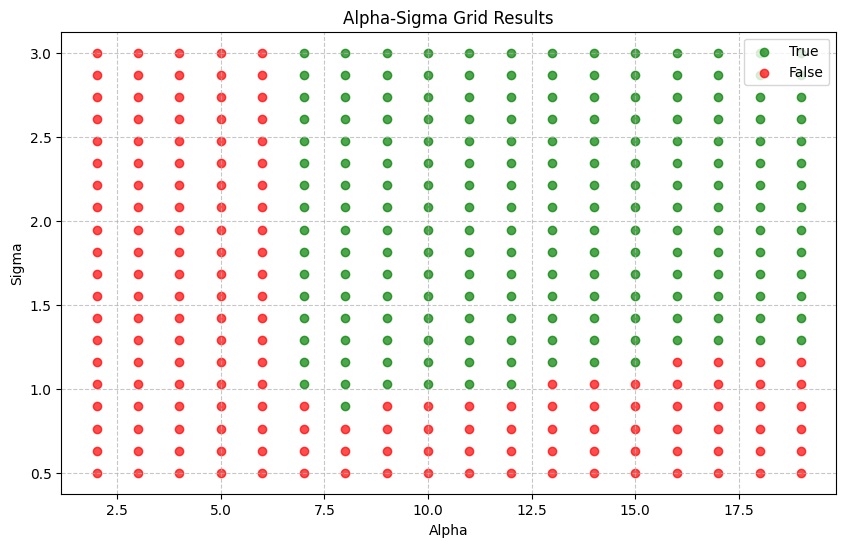

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define your ranges for alpha and sigma
alphas = np.arange(2, 20, 1)          # Integer values for alpha
sigmas = np.linspace(0.5, 3, 20)   # Real values for sigma

# Create lists to store the points
true_alphas, true_sigmas = [], []
false_alphas, false_sigmas = [], []
opt_sigma = 100000
opt_alpha = None
# Fill the lists based on your boolean condition
for alpha in alphas:
    for sigma in sigmas:
        if check_exp_parameters(alpha, 1/300, sigma, 1000, 1, 1/300*1.1):
            true_alphas.append(alpha)
            true_sigmas.append(sigma)
            if sigma < opt_sigma:
                opt_sigma = sigma
                opt_alpha = alpha
        else:
            false_alphas.append(alpha)
            false_sigmas.append(sigma)

print(f"Optimal sigma is {opt_sigma} for {opt_alpha=}")
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(true_alphas, true_sigmas, color='green', label='True', alpha=0.7)
plt.scatter(false_alphas, false_sigmas, color='red', label='False', alpha=0.7)

plt.xlabel('Alpha')
plt.ylabel('Sigma')
plt.title('Alpha-Sigma Grid Results')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## Introducing Heavy Tails (inactive)

(5000, 3)


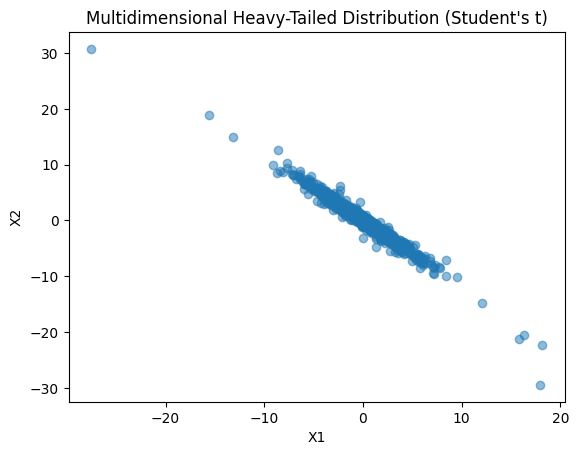

In [2]:
import math

import numpy as np

def generate_heavy_tailed_distribution(n_samples=1000, df=3, dim=3, seed=219):
    np.random.seed(seed)

    # Mean vector (center of distribution)
    mean = np.zeros(dim)

    # Covariance matrix (random positive-definite matrix)
    A = np.random.randn(dim, dim)
    cov_matrix = np.dot(A, A.T)  # Ensures it's positive semi-definite

    # Generate multivariate normal samples
    normal_samples = np.random.multivariate_normal(mean, cov_matrix, size=n_samples)

    # Generate chi-squared distributed samples
    chi_samples = np.random.chisquare(df, size=(n_samples, 1))

    # Compute heavy-tailed Student’s t-distributed samples
    t_samples = normal_samples / np.sqrt(chi_samples / df)

    return t_samples

# Generate samples
samples = generate_heavy_tailed_distribution(n_samples=5000)

# Display shape
print(samples.shape)

# Optionally, visualize one 2D projection
import matplotlib.pyplot as plt

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Multidimensional Heavy-Tailed Distribution (Student's t)")
plt.show()


For now, basic code is without heavy-tailed noise. Instead I use a normal noise.

## Precise DP-accountant

In [123]:
import math
def compute_sigma(sample_ratio, iterations, epsilon_threshold=10):
    # delta = 1/n**1.1 -- not required
    exp_es = 1 + epsilon_threshold / sample_ratio / math.sqrt(iterations)
    es = math.log(exp_es)
    sigma = 1.25 / math.exp(math.sqrt(es) / 2)
    return 3 # I wanted to test numerically for Mironov2019 with Poisson. Now this is outdates, as the accounting was messy

In [64]:
compute_sigma(1/100, 10000, 1.26)

0.795850268914769

In [161]:
import numpy as np
from scipy.stats import norm

def dp_sign_precise(g_t_m, epsilon, delta, sens_measure2, iteration_num, q):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2
    # Compute standard deviation sigma
    sigma = sens_measure2 * find_min_sigma(q, iteration_num, epsilon, delta)
    # compute_sigma(sample_ratio, iteration_num, epsilon)

    # Compute probabilities using the CDF of standard normal distribution
    probabilities = norm.cdf(g_t_m / sigma)

    # Sample from {1, -1} based on computed probabilities
    signs = np.where(np.random.rand(*g_t_m.shape) < probabilities, 1, -1)
    return signs

In [170]:
import numpy as np
from scipy.stats import norm

def dp_sign_by_sigma(g_t_m, sens_measure2, sigma):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2

    # Compute probabilities using the CDF of standard normal distribution
    probabilities = norm.cdf(g_t_m / sigma)

    # Sample from {1, -1} based on computed probabilities
    signs = np.where(np.random.rand(*g_t_m.shape) < probabilities, 1, -1)
    return signs

## DP-Sign (outdated)

In [33]:
import numpy as np
def topk(v, k):
    """
    Top-k sparsifier: retains only the top-k entries (by absolute value) of vector v.
    
    Parameters:
    - v (np.ndarray): Input vector.
    - k (int): Number of top entries to keep.
    
    Returns:
    - np.ndarray: Sparsified vector with only top-k elements retained.
    """
    if k >= v.size:
        return v.copy()

    # Get indices of the top-k absolute values
    topk_indices = np.argpartition(np.abs(v), -k)[-k:]

    # Create zero vector and fill in top-k entries
    sparse_v = np.zeros_like(v)
    sparse_v[topk_indices] = v[topk_indices]

    return sparse_v

In [256]:
import numpy as np
from scipy.stats import norm

def dp_sign(g_t_m, epsilon, delta, sens_measure2):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2
    # Compute standard deviation sigma
    sigma = sens_measure2 / epsilon * np.sqrt(2 * np.log(1.25 / delta))

    # Compute probabilities using the CDF of standard normal distribution
    probabilities = norm.cdf(g_t_m / sigma)

    # Sample from {1, -1} based on computed probabilities
    signs = np.where(np.random.rand(*g_t_m.shape) < probabilities, 1, -1)
    return signs


In [263]:
dp_sign(np.array([1400, 2003, 300]), 10, 100000e-5, 4)

array([1, 1, 1])

In [249]:
import numpy as np
from scipy.stats import norm

def renyi_dp_sign(g_t_m, epsilon_dp, delta_dp, sens_measure2, alpha_renyi, max_iter):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2
    # Compute standard deviation sigma
    # sigma = sens_measure2 / epsilon * np.sqrt(2 * np.log(1.25 / delta))
    sigma = np.sqrt(max_iter * alpha_renyi * sens_measure2**2 / 2 / (epsilon_dp - np.log(1/delta_dp)/(alpha_renyi - 1)))
    # print(sigma)
    # Compute probabilities using the CDF of standard normal distribution
    probabilities = norm.cdf(g_t_m / sigma)

    # Sample from {1, -1} based on computed probabilities
    signs = np.where(np.random.rand(*g_t_m.shape) < probabilities, 1, -1)
    return signs


In [250]:
renyi_dp_sign(np.array([-14, 23, -3]), 1000000, 10e-5, 4, 3, 1000)

array([-1,  1, -1])

In [75]:
from functools import lru_cache

@lru_cache(maxsize=10)
def cached_power_sum(max_iter: int, sig_power: float) -> float:
    return sum(1 / (i ** sig_power) for i in range(1, max_iter + 1))

In [159]:
import numpy as np
from scipy.stats import norm

def renyi_dp_sign_dynamic(g_t_m, epsilon_dp, delta_dp, sens_measure2, alpha_renyi, max_iter, current_iter, sig_power):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    sigma_i = (i)**sig_power * sigma0
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2
    # Compute standard deviation sigma
    # sigma = sens_measure2 / epsilon * np.sqrt(2 * np.log(1.25 / delta))
    sigma = np.sqrt(max_iter * alpha_renyi * sens_measure2**2 / 2 / (epsilon_dp - np.log(1/delta_dp)/(alpha_renyi - 1)))
    
    sigma0 = sigma * np.sqrt(cached_power_sum(max_iter, 2 * sig_power)/max_iter)
    if current_iter == 1:
        print(f"sigma0={sigma0}")
    if current_iter == 200:
        print(f"sigma200={sigma0 * current_iter**sig_power}")
    # Compute probabilities using the CDF of standard normal distribution
    probabilities = norm.cdf(g_t_m / sigma0 / current_iter**sig_power)

    # Sample from {1, -1} based on computed probabilities
    signs = np.where(np.random.rand(*g_t_m.shape) < probabilities, 1, -1)
    return signs


In [158]:
2491828 * 500**-3

0.019934624

## Loading and Preparing data

In [196]:
import numpy as np
from scipy.stats import norm

def renyi_dp_noise(g_t_m, epsilon_dp, delta_dp, sens_measure2, alpha_renyi, max_iter):
    """
    Differentially Private Sign compressor (dp-sign) implementation.
    
    Parameters:
    - g_t_m (np.ndarray): Gradient vector at time t for model m.
    - epsilon (float): Differential privacy parameter epsilon.
    - delta (float): Differential privacy parameter delta.
    - Delta2 (float): Sensitivity parameter ∆2.
    
    Returns:
    - np.ndarray: DP-compressed sign vector of the same shape as g_t_m.
    """
    l2_norm = np.linalg.norm(g_t_m)
    if l2_norm > sens_measure2:
        g_t_m = (g_t_m / l2_norm) * sens_measure2
    # Compute standard deviation sigma
    # sigma = sens_measure2 / epsilon * np.sqrt(2 * np.log(1.25 / delta))
    sigma = np.sqrt(max_iter * alpha_renyi * sens_measure2**2 / 2 / (epsilon_dp - np.log(1/delta_dp)/(alpha_renyi - 1)))
    return g_t_m + np.random.normal(0, sigma * sens_measure2, size=g_t_m.shape)

In [4]:
import requests
from sklearn.datasets import load_svmlight_file

# URL of the file to download
url = 'https://hse24.fmin.xyz/files/mushrooms.txt'

# Download the file and save it locally
response = requests.get(url)
dataset = 'mushrooms.txt'

# Ensure the request was successful
if response.status_code == 200:
    with open(dataset, 'wb') as f:
        f.write(response.content)

    # Load the dataset from the downloaded file
    data = load_svmlight_file(dataset)
    A, b = data[0].toarray(), data[1]
    n, d = A.shape
    b = (b - 3/2) * 2 # to +-1
    print("Data loaded successfully.")
    print(f"Number of samples: {n}, Number of features: {d}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Data loaded successfully.
Number of samples: 8124, Number of features: 112


In [18]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
# Number of workers
num_workers = 20

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=214)

# Initialize empty lists for workers
X_splits, y_splits = [], []

X_remaining, y_remaining = A_train, b_train
for _ in range(num_workers - 1):  # Last worker gets remaining data
    X_part, X_remaining, y_part, y_remaining = train_test_split(
        X_remaining, y_remaining, train_size=1/(num_workers - len(X_splits)), stratify=y_remaining
    )
    X_splits.append(X_part)
    y_splits.append(y_part)

X_splits.append(X_remaining)  # Last split
y_splits.append(y_remaining)

# Workers' data
workers_data = list(zip(X_splits, y_splits))

workers_data[0][0].shape

(324, 112)

## Functions for conducting experiments

### Tools for backups

In [5]:
import pickle

def pickle_data(data, data_name, version_name):
    with open(f"../data/{version_name}/{data_name}_{version_name}.pkl", "wb") as f:
        pickle.dump(data, f)

### Functions for logistic regression

In [6]:
from jax import jit
import jax.numpy as jnp
@jit
def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

In [7]:
def compute_objective_regression(mat_A, vec_b, point_w, reg_const):
    log_terms = np.log(1 + np.exp(-vec_b * (mat_A @ point_w)))
    reg_term = (reg_const/2) * np.linalg.norm(point_w)**2
    return np.mean(log_terms) + reg_term

def compute_gradient_regression(mat_A, vec_b, point_w, reg_const):
    m = mat_A.shape[0]
    sigmoid_vec = 1 / (1 + np.exp(vec_b * (mat_A @ point_w)))
    return (1/m) * mat_A.T @ (-vec_b * sigmoid_vec) + reg_const * point_w


In [8]:
def compute_all_gradients_regression(mat_A, vec_b, point_w, reg_const):
    m = mat_A.shape[0]
    gradients = []

    # Loop through each row in mat_A (each sample)
    for i in range(m):
        sigmoid_val = 1 / (1 + np.exp(vec_b[i] * (mat_A[i] @ point_w)))
        gradient = (-vec_b[i] * sigmoid_val) * mat_A[i] + reg_const * point_w
        gradients.append(gradient)

    return gradients

In [9]:
import cvxpy as cp
def compute_optimal_regression(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

In [10]:
@jit
def compute_accuracy(w, X, y):
    # Compute predicted probabilities using the logistic (sigmoid) function
    preds_probs = jax.nn.sigmoid(X @ w)
    # Convert probabilities to class predictions: -1 if p < 0.5, else 1
    preds = jnp.where(preds_probs < 0.5, -1, 1)
    # Calculate accuracy as the average of correct predictions
    accuracy = jnp.mean(preds == y)
    return accuracy

In [11]:
import jax.numpy as jnp
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu):
    f = lambda w: logistic_loss(w, X_train, y_train, mu)
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
    }
    return metrics

## Algorithms

In [12]:
def sign_grad(grad):
    return np.sign(grad)

In [190]:
not (np.random.rand(10) < 0.001).any()

True

In [208]:
import numpy as np
import random
import time


def regression_gradient_descent(w_init, work_data, alpha, max_iter, lambda_reg, alg='gd', noise=None, send_time=1e-4):
    times = [0]
    iter_start = time.time()

    trajectory = [w_init.copy()]
    w = w_init.copy()
    send_timer = 0
    for current_iter in range(max_iter):
        sum_grads = 0
        for mat_A, vec_b in work_data: # checking different users
            if alg != 'dp_sign_sgd_precise':
                pure_grad = compute_gradient_regression(mat_A, vec_b, w, lambda_reg)
            else:
                q = 2 / mat_A.shape[0]
                dp_sigma = find_min_sigma(q, max_iter, 3, 1/(mat_A.shape[0])**1.1, alpha_max=10, sigma_max=1.2)
                # random_ind = np.random.randint(0, mat_A.shape[0])
                # random_sample = np.array(random.sample(range(1, mat_A.shape[0]), 10)) -- not Poisson
                included = np.random.rand(mat_A.shape[0]) < q  # Poisson
                is_empty_subsample = False
                if not included.any():
                    is_empty_subsample = True
                    pure_grad = 0 # dummy
                else:
                    pure_grad = compute_gradient_regression(mat_A[included, :], vec_b[included], w, lambda_reg)
            # pure_grads = compute_all_gradients_regression(mat_A, vec_b, w, lambda_reg)
            noise_grad = np.random.normal(0, 1/2, w.shape) if noise == 'normal' else 0
            grad = pure_grad + noise_grad
            # grads = pure_grads # TO-DO: add noise!
            if alg=='gd':
                sum_grads += grad
                send_timer += send_time * 8 # because floats instead of bools
            '''
            if alg=='dp_sgd':
                sum_user_grads = 0
                for user_grad in grads:
                    sum_user_grads += renyi_dp_noise(user_grad, 10, 10e-5, 5, 30, max_iter)    
                # sum_grads += renyi_dp_noise(grad, 10, 10e-5, 4, 30, max_iter)
                send_timer += send_time * 8 # because floats instead of bools
                sum_grads += sum(sum_user_grads)/len(grads)
            '''
            if alg =='sign_sgd':
                sum_grads += np.sign(grad)
                send_timer += send_time
            if alg =='chinese_dp':
                sum_grads += dp_sign(grad, 10/max_iter, 10e-5/max_iter, 5)
                send_timer += send_time
            if alg =='chinese_dp_cheat':
                sum_grads += dp_sign(grad, 10, 10e-5, 5)
                send_timer += send_time
            if alg =='dp_sign_sgd':
                sum_grads += renyi_dp_sign(grad, 10, 10e-5, 5, 30, max_iter)
                # sum_grads += renyi_dp_sign_dynamic(grad, 10, 10e-5, 4, 30, max_iter, current_iter + 1, -0.5)
                send_timer += send_time
            if alg == 'dp_sign_sgd_precise':
                # dp_sign_precise(grad, 10, 1/(mat_A.shape[0])**1.1, 5, max_iter, 10/mat_A.shape[0])
                if not is_empty_subsample:
                    sum_grads += dp_sign_by_sigma(grad, 5, dp_sigma)
        if alg == 'gd' or alg == 'dp_sgd':
            w = w - alpha * sum_grads / len(work_data)
        if alg in {'sign_sgd', 'dp_sign_sgd', 'chinese_dp', 'chinese_dp_cheat', 'dp_sign_sgd_precise'}:
            w = w - alpha * sign_grad(sum_grads)


        trajectory.append(w.copy())        
        iter_time = time.time()
        times.append(iter_time - iter_start + send_timer)

    return trajectory, times



### Runner of experiments

In [14]:
import jax
def run_experiments(params):
    mu = params["mu"]
    methods = params["methods"]
    sending_time = params["sending_time"]

    results = {}

    X_train = A_train
    y_train = b_train
    X_test = A_test
    y_test = b_test
    n_features = X_train.shape[1]  # Number of features
    params["n_features"] = n_features

    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, ))
    # x_0 = np.ones(n_features)
    x_star, f_star = compute_optimal_regression(X_train, y_train, mu)
    methods_dict = {"SGD": 'gd', "DP-SignSGD": 'dp_sign_sgd', "SignSGD": 'sign_sgd', "DP-SGD": 'dp_sgd', 
                    "Chinese-DP-SignSGD": 'chinese_dp', "Chinese-DP-SignSGD-cheat": 'chinese_dp_cheat',
                    "DP-SGD Precise": 'dp_sign_sgd_precise'}
    for method in methods:
        learning_rate = method["learning_rate"]
        iterations = method["iterations"]
        noise = method["noise_type"]
        trajectory, times = regression_gradient_descent(x_0, workers_data, learning_rate, iterations, mu, alg=methods_dict[method["method"]], noise=noise, send_time=sending_time)
        label = f'{method["method"]}' # with lr {round(learning_rate, 3)}' #  with {noise} noise and '
        results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        
    return results, params
    

### Presenter of experiments

In [15]:
import os
import matplotlib.pyplot as plt
def plot_long_results(results, params, code_version):
    plt.figure(figsize=(11, 5))
    mu = params["mu"]
    sending_time = params["sending_time"]
    if mu > 1e-2:
        title_str = f"Strongly convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit"
    else:
        title_str = f"Convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit"

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}"
    folder_path = f"../figs/{code_version}/long/"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    os.makedirs(folder_path, exist_ok=True)
    filename = code_version
    plt.savefig(os.path.join(folder_path, filename + "_long.pdf"))
    with open(folder_path + filename + '_long.txt', 'w') as output:
        output.write(title_str)

    plt.show()

In [61]:
import os
import matplotlib.pyplot as plt
def plot_short_results(results, params, code_version):
    plt.figure(figsize=(12, 4))
    mu = params["mu"]
    sending_time = params["sending_time"]
    if mu > 1e-2:
        title_str = f"Strongly convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit"
    else:
        title_str = f"Convex binary logistic regression. mu={mu}. {len(workers_data)} workers. \
                     Sending time is {sending_time * 1000} ms per bit"

    plt.subplot(1, 3, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 3)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")
    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}"
    filename = code_version
    folder_path = f"../figs/{code_version}/short/"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    os.makedirs(folder_path, exist_ok=True)
    plt.savefig(os.path.join(folder_path, filename + "_short.pdf"))
    with open(folder_path + filename + '_short.txt', 'w') as output:
        output.write(title_str)
    plt.show()

## Comparing the algorithms

In [172]:
code_version = 'v16dps2'

In [209]:
iterations = 10000
feature_num = 22
basic_lr = 1/np.sqrt(iterations * feature_num)
params = {
    "mu": 1e-3,
    "sending_time": 0,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 0.2,
            "iterations": 1000,
            "noise_type": "no",
        },
        {
            "method": "DP-SGD Precise",
            "learning_rate": basic_lr,
            "iterations": iterations,
            "noise_type": "no",
        },
    ]
}

results, params = run_experiments(params)

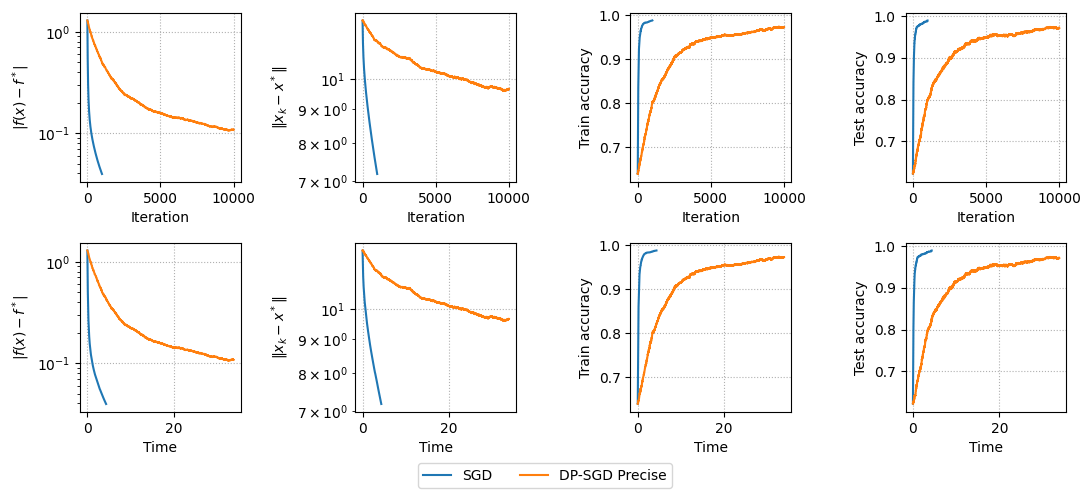

In [210]:
plot_long_results(results, params, code_version)

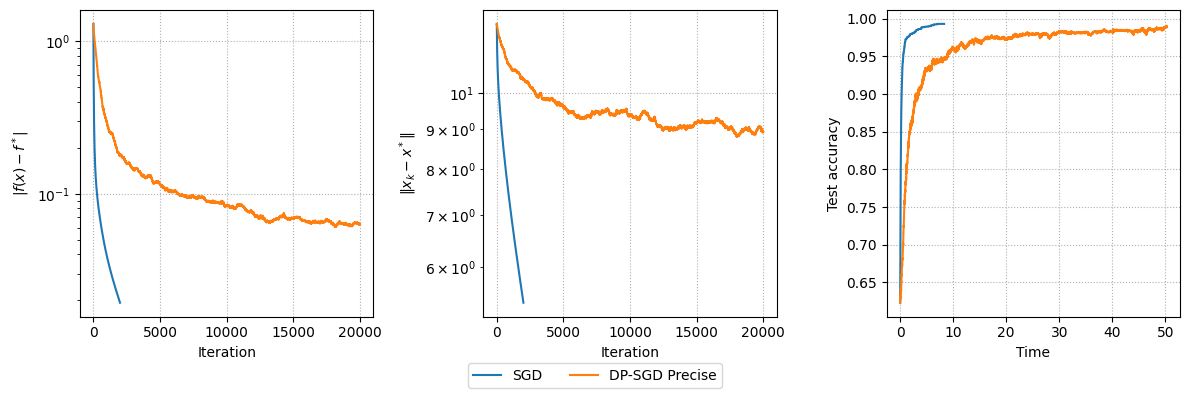

In [202]:
plot_short_results(results, params, code_version)

### DP-SGD by ChatGPT

In [176]:
import numpy as np

def private_gradient_descent(
        X, y, loss_fn, grad_fn,
        learning_rates, a, epsilon_rdp,
        clip_value=1.0, num_steps=100,
        theta_init=None, random_seed=None
):
    """
    Implements Algorithm 6: Private Gradient Descent (RDP version)

    Inputs:
    - X: data matrix (n, d)
    - y: labels vector (n,)
    - loss_fn: callable loss(theta, X, y)
    - grad_fn: callable grad(theta, x_i, y_i) -> gradient vector
    - learning_rates: list or array of learning rates for each step
    - a: RDP order α > 1
    - epsilon_rdp: desired RDP budget ε_RDP
    - clip_value: clipping bound C
    - num_steps: number of gradient steps
    - theta_init: initial parameter vector
    """

    n, d = X.shape
    if theta_init is None:
        theta = np.zeros(d)
    else:
        theta = theta_init.copy()

    # Compute required sigma
    sigma = np.sqrt((num_steps * a * clip_value**2) / (2 * epsilon_rdp))

    rng = np.random.default_rng(random_seed)

    for t in range(num_steps):
        grads = np.array([
            grad_fn(theta, X[i], y[i]) for i in range(n)
        ])  # shape: (n, d)

        # Clip gradients
        grad_norms = np.linalg.norm(grads, axis=1, keepdims=True)
        scale = np.minimum(1.0, clip_value / (grad_norms + 1e-12))
        clipped_grads = grads * scale

        # Add Gaussian noise
        noise = rng.normal(loc=0.0, scale=sigma * clip_value, size=(n, d))
        noisy_avg_grad = np.mean(clipped_grads + noise, axis=0)

        # Gradient descent step
        eta = learning_rates[t] if isinstance(learning_rates, (list, np.ndarray)) else learning_rates
        theta -= eta * noisy_avg_grad

        # Optional: print loss
        if (t+1) % 10 == 0 or t == 0:
            loss = loss_fn(theta, X, y)
            print(f"Step {t+1}/{num_steps}: Loss = {loss:.4f}")

    return theta, sigma


In [177]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_loss(theta, X, y):
    logits = X @ theta
    preds = sigmoid(logits)
    return -np.mean(y * np.log(preds + 1e-10) + (1 - y) * np.log(1 - preds + 1e-10))

def logistic_grad(theta, x_i, y_i):
    pred = sigmoid(np.dot(theta, x_i))
    return (pred - y_i) * x_i

# Data
np.random.seed(42)
X = np.random.randn(1000, 5)
true_theta = np.array([0.5, -0.2, 0.3, 0.0, 0.1])
y = (sigmoid(X @ true_theta) > 0.5).astype(np.float32)

# Run Private Gradient Descent
theta_final, used_sigma = private_gradient_descent(
    X, y,
    loss_fn=logistic_loss,
    grad_fn=logistic_grad,
    learning_rates=0.5,
    a=10,
    epsilon_rdp=1.0,  # <- user-specified RDP budget
    clip_value=1.0,
    num_steps=100,
    random_seed=42
)

print("Final parameters:", theta_final)
print("Used σ (noise scale):", used_sigma)


Step 1/100: Loss = 0.5134
Step 10/100: Loss = 0.5053
Step 20/100: Loss = 0.2885
Step 30/100: Loss = 0.1950
Step 40/100: Loss = 0.3818
Step 50/100: Loss = 0.2526
Step 60/100: Loss = 0.3320
Step 70/100: Loss = 0.2233
Step 80/100: Loss = 0.2770
Step 90/100: Loss = 0.1837
Step 100/100: Loss = 0.1318
Final parameters: [ 5.69233957 -1.55513309  3.37927941 -0.50802142  0.72398565]
Used σ (noise scale): 22.360679774997898
